<a href="https://colab.research.google.com/github/hushee69/biobert-relation-extraction/blob/main/relation_extraction_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
import numpy as np;
import pandas as pd;

import torch;

from transformers import BertTokenizer;

In [3]:
# load dataset
# labels = {0, 1}
# relation between gene and disease if label = 0
# and vice versa is true
df = pd.read_csv('./train.tsv', delimiter='\t', header=None, names=['text', 'label']);
df.sample(5)

,text,label
2774,in Japan the [-215G > A; IVS3 + 2T > C] mutati...,1
494,Our data suggest that the @GENE$ Y402H polymor...,1
2179,The above described findings indicate that Arg...,0
3800,"In summary, a rare P387L variant of the PTP-1B...",1
1450,The @GENE$ Gly146Ala variation may constitute ...,0


In [4]:
print(df.loc[df.label == 1].sample(5));

                                                   text  label
3369  Although SERT genotype was not reliably associ...      1
419          @GENE$ may be an important @DISEASE$ gene.      1
522   our data suggests that the @GENE$ D allele is ...      1
1641  We therefore conclude that Tnfsf4 underlies At...      1
1665  No differences in frequencies of the @GENE$ de...      1


In [5]:
print(df.loc[df.label == 0].sample(5));

                                                   text  label
493   IVS14A and 451Q @DISEASE$ of @GENE$ gene were ...      0
3250  Considering population stratification, previou...      0
4599  In conclusion, these findings suggest that @GE...      0
3700  Although the studied polymorphisms have been p...      0
2411  the ACE2 T allele confers a high risk for @DIS...      0


In [6]:
sentences = df.text.values;
sent_labels = df.label.values;

In [7]:
# tokenize
# add special tokens [CLS] to start of sentence and [SEP] to the end of each sentence
# pad and truncate to single constant length
# explicitly differentiate real tokens from padding tokens with 'attention mask'

In [8]:
# find maximum length
# BERT accepts 512 as maximum sentence length
max_len = 0;

for i, sent in enumerate(sentences):
    if len(sent) > max_len:
        max_len = len(sent);
        idx = i;


print('maximum sentence length: {}'.format(max_len));
print('index: {}'.format(idx));

maximum sentence length: 538
index: 3171


In [9]:
print(sentences[182]);

The AA genotype of HMOX1 reduced the incidence of @DISEASE$, possibly due to the high expression level of @GENE$.


In [10]:
# we will truncate to 128
if max_len > 512:
    max_len = 128;

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased');

In [12]:
input_ids = [];
attention_masks = [];

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    );

    input_ids.append(encoded_dict['input_ids']);
    attention_masks.append(encoded_dict['attention_mask']);

# convert lists into tensors
input_ids = torch.cat(input_ids, dim=0);
attention_masks = torch.cat(attention_masks, dim=0);
labels = torch.tensor(sent_labels);

print('original sentence: {}'.format(sentences[0]));
print('tokenized: {}'.format(input_ids[0].shape));

original sentence: this study proposes that A/A genotype at position -607 in @GENE$ gene can be used as a new genetic maker in Thai population for predicting @DISEASE$ development.
tokenized: torch.Size([128])


In [13]:
from torch.utils.data import TensorDataset, random_split;

In [14]:
dataset = TensorDataset(input_ids, attention_masks, labels);

train_size = int(0.9 * len(dataset));
val_size = len(dataset) - train_size;

train_dataset, val_dataset = random_split(dataset, [train_size, val_size]);
print('{:>5,} training samples'.format(train_size));
print('{:>5,} validation samples'.format(val_size));

4,316 training samples
  480 validation samples


In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler;

In [16]:
batch_size = 32;

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
);

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
);

In [17]:
# get cuda device
# train model
# classification task

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else print('no gpu found');

In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig;

In [20]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
);

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8
);

In [22]:
from transformers import get_linear_schedule_with_warmup;

In [23]:
epochs = 4;

total_steps = len(train_dataloader) * epochs;

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
);

In [24]:
def accuracy(preds, labels):
    preds = np.argmax(preds, axis=1).flatten();
    labels = labels.flatten();

    return np.sum(preds == labels) / len(labels);

In [29]:
max_val_loss = np.float('inf');

for e in range(epochs):
    train_loss = 0;
    train_acc = 0;

    model.train();

    for batch in train_dataloader:
        b_input_ids = batch[0].to(device);
        b_input_mask = batch[1].to(device);
        b_labels = batch[2].to(device);

        model.zero_grad();

        output = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        );

        loss = output['loss'];
        preds = output['logits'].detach().cpu().numpy();
        labels = b_labels.to('cpu').numpy();

        train_loss += loss.item();
        train_acc += accuracy(preds, labels);

        loss.backward();

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0);

        optimizer.step();

        scheduler.step();
    
    avg_train_loss = train_loss / len(train_dataloader);
    avg_train_acc = train_acc / len(train_dataloader);

    print('average training loss for epoch: {}'.format(avg_train_loss));
    print('average training accuracy for epoch: {}'.format(avg_train_acc));

    # validation
    val_loss = 0;
    val_acc = 0;

    model.eval();

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device);
        b_attention_mask = batch[1].to(device);
        b_labels = batch[2].to(device);

        with torch.no_grad():
            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_attention_mask,
                labels=b_labels
            );
        
        loss = output['loss'];
        preds = output['logits'].detach().cpu().numpy();
        labels = b_labels.to('cpu').numpy();

        val_loss += loss.item();
        val_acc += accuracy(preds, labels);
    
    avg_val_loss = val_loss / len(val_dataloader);
    avg_val_acc = val_acc / len(val_dataloader);

    if avg_val_loss < max_val_loss:
        max_val_loss = avg_val_loss;
        torch.save(model.state_dict(), 'best_model.pt');

    print('average validation loss for epoch: {}'.format(avg_val_loss));
    print('average validation accuracy for epoch: {}'.format(avg_val_acc));

average training loss for epoch: 0.34845350119802687
average training accuracy for epoch: 0.8618716931216931
average validation loss for epoch: 0.5348166028658549
average validation accuracy for epoch: 0.7729166666666667
average training loss for epoch: 0.3431510994831721
average training accuracy for epoch: 0.8634589947089948
average validation loss for epoch: 0.5348166028658549
average validation accuracy for epoch: 0.7729166666666667
average training loss for epoch: 0.3471738624351996
average training accuracy for epoch: 0.8624669312169312
average validation loss for epoch: 0.5348166028658549
average validation accuracy for epoch: 0.7729166666666667
average training loss for epoch: 0.34190624875051007
average training accuracy for epoch: 0.8639550264550264
average validation loss for epoch: 0.5348166028658549
average validation accuracy for epoch: 0.7729166666666667


In [30]:
test_df = pd.read_csv('./test.tsv', delimiter='\t', index_col=0);

test_df.head()

,sentence,label
index,,
0,Our work supported @GENE$ genetic variants as ...,1
1,"Especially, the SNP @GENE$ and its strongly as...",1
2,"Especially, the SNP rs491347 and its strongly ...",1
3,The HBS1L-MYB intergenic region on chromosome ...,0
4,Fetal haemoglobin (@GENE$) level modifies the ...,1


In [31]:
# do same preprocessing for test data
test_sentences = test_df.sentence.values;
test_labels = test_df.label.values;

test_input_ids = [];
test_attention_mask = [];

for sent in test_sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    );

    test_input_ids.append(encoded_dict['input_ids']);
    test_attention_mask.append(encoded_dict['attention_mask']);

test_input_ids = torch.cat(test_input_ids, dim=0);
test_attention_mask = torch.cat(test_attention_mask, dim=0);
test_labels = torch.tensor(test_labels);

batch_size = 32;

prediction_data = TensorDataset(test_input_ids, test_attention_mask, test_labels);
prediction_dataloader = DataLoader(prediction_data, sampler=SequentialSampler(prediction_data), batch_size=batch_size);

print('nbr of test sentences: {}'.format(len(prediction_data)));

nbr of test sentences: 37


In [33]:
model.load_state_dict(torch.load('best_model.pt'));

model.eval();

preds, real_labels = [], [];

for batch in prediction_dataloader:
    b_input_ids = batch[0].to(device);
    b_input_mask = batch[1].to(device);
    b_labels = batch[2].to(device);

    with torch.no_grad():
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        );
    
    logits = outputs['logits'].detach().cpu().numpy();
    label_ids = b_labels.to('cpu').numpy();

    preds.append(logits);
    real_labels.append(label_ids);

In [51]:
import matplotlib.pyplot as plt;

In [52]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x));

In [67]:
# first batch predictions

# second batch
preds_1 = preds[1];
preds_1 = sigmoid(preds_1);
print(preds_1);
preds_1 = np.argmax(preds_1, axis=1);
print(preds_1);
print(real_labels[1]);

[[0.39673707 0.6232959 ]
 [0.27848536 0.734083  ]
 [0.45340356 0.5849016 ]
 [0.30799952 0.7329959 ]
 [0.62844443 0.40633217]]
[1 1 1 1 0]
[1 1 1 1 1]


In [66]:
print(accuracy(preds[1], real_labels[1]));

0.8


[ 0.          1.03225806  2.06451613  3.09677419  4.12903226  5.16129032
  6.19354839  7.22580645  8.25806452  9.29032258 10.32258065 11.35483871
 12.38709677 13.41935484 14.4516129  15.48387097 16.51612903 17.5483871
 18.58064516 19.61290323 20.64516129 21.67741935 22.70967742 23.74193548
 24.77419355 25.80645161 26.83870968 27.87096774 28.90322581 29.93548387
 30.96774194 32.        ]


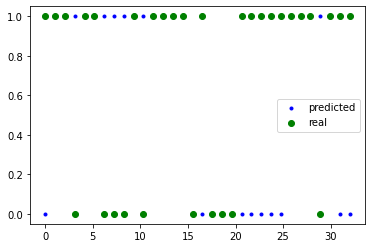

In [61]:
x = np.linspace(0, len(preds_1), len(preds_1));
print(x);
plt.scatter(x, preds_1, marker='.', color='b', label='predicted');
plt.scatter(x, real_labels[0], color='g', label='real');
plt.legend();

# Conclusion
Comme il y a pas beaucoup de données, le modèle est biasé.

**Travail à faire:**
- Entrainer le modèle sur toutes les données train de EU-ADR